In [6]:
# Import the function to get connect to the db
from snowexsql.db import get_db

# Import our class for the points table
from snowexsql.data import PointData

# Import a useful function to format that data into a dataframe
from snowexsql.conversions import query_to_geopandas

# Import some tools to build dates 
from datetime import date

# This is what you will use for all of hackweek to access the db
db_name = 'snow:hackweek@52.32.183.144/snowex'

# Using the function get_db, we receive 2 ways to interact with the database
engine, session = get_db(db_name)

In [11]:
# !pip install pigeon-jupyter
!conda install -c conda-forge opencv

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.9.2
  latest version: 4.10.3

Please update conda by running

    $ conda update -n base conda



# All requested packages already installed.



In [13]:
import cv2

In [7]:
from snowexsql.db import get_db
from snowexsql.data import LayerData, PointData
from snowexsql.conversions import points_to_geopandas, query_to_geopandas

import geoalchemy2.functions as gfunc
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

import cv2



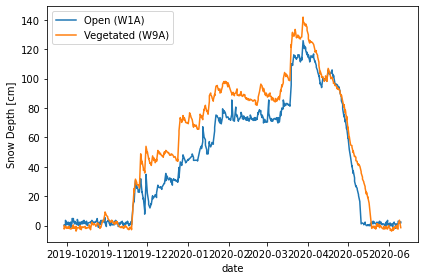

In [8]:
# Grab the open site data from the db
open_site = 'W1A'
veg_site = 'W9A'
qry = session.query(PointData).filter(PointData.equipment.contains(open_site))
df_open = query_to_geopandas(qry,engine)

# Grab the vegetated site from the db
qry = session.query(PointData).filter(PointData.equipment.contains(veg_site))
df_veg = query_to_geopandas(qry,engine)

# Set the date as the index for easy plotting/reading
df_open2 = df_open.set_index('date')
df_veg2 = df_veg.set_index('date')

# Plot the 2 datasets by date!
ax = df_open2['value'].plot(label=f'Open ({open_site})')
df_veg2['value'].plot(ax=ax, label=f'Vegetated ({veg_site})')

# Mess with some labeling to make it look nice
ax.legend()
ax.set_ylabel('Snow Depth [cm]')
plt.tight_layout()
plt.show()

In [9]:
from pigeon import annotate
import os
from IPython.display import Image
files = os.listdir('/tmp/camera-trap/W9A')
annotations = annotate(
    ['/tmp/camera-trap/W9A/' + str(f) for f in files],
  options=['interception', 'no interception'],
  display_fn=lambda filename: display(Image(filename,width = 600, height = 300))
)


HTML(value='0 examples annotated, 657 examples left')

Output()

In [75]:
files[2]

'WSCT0007.JPG'

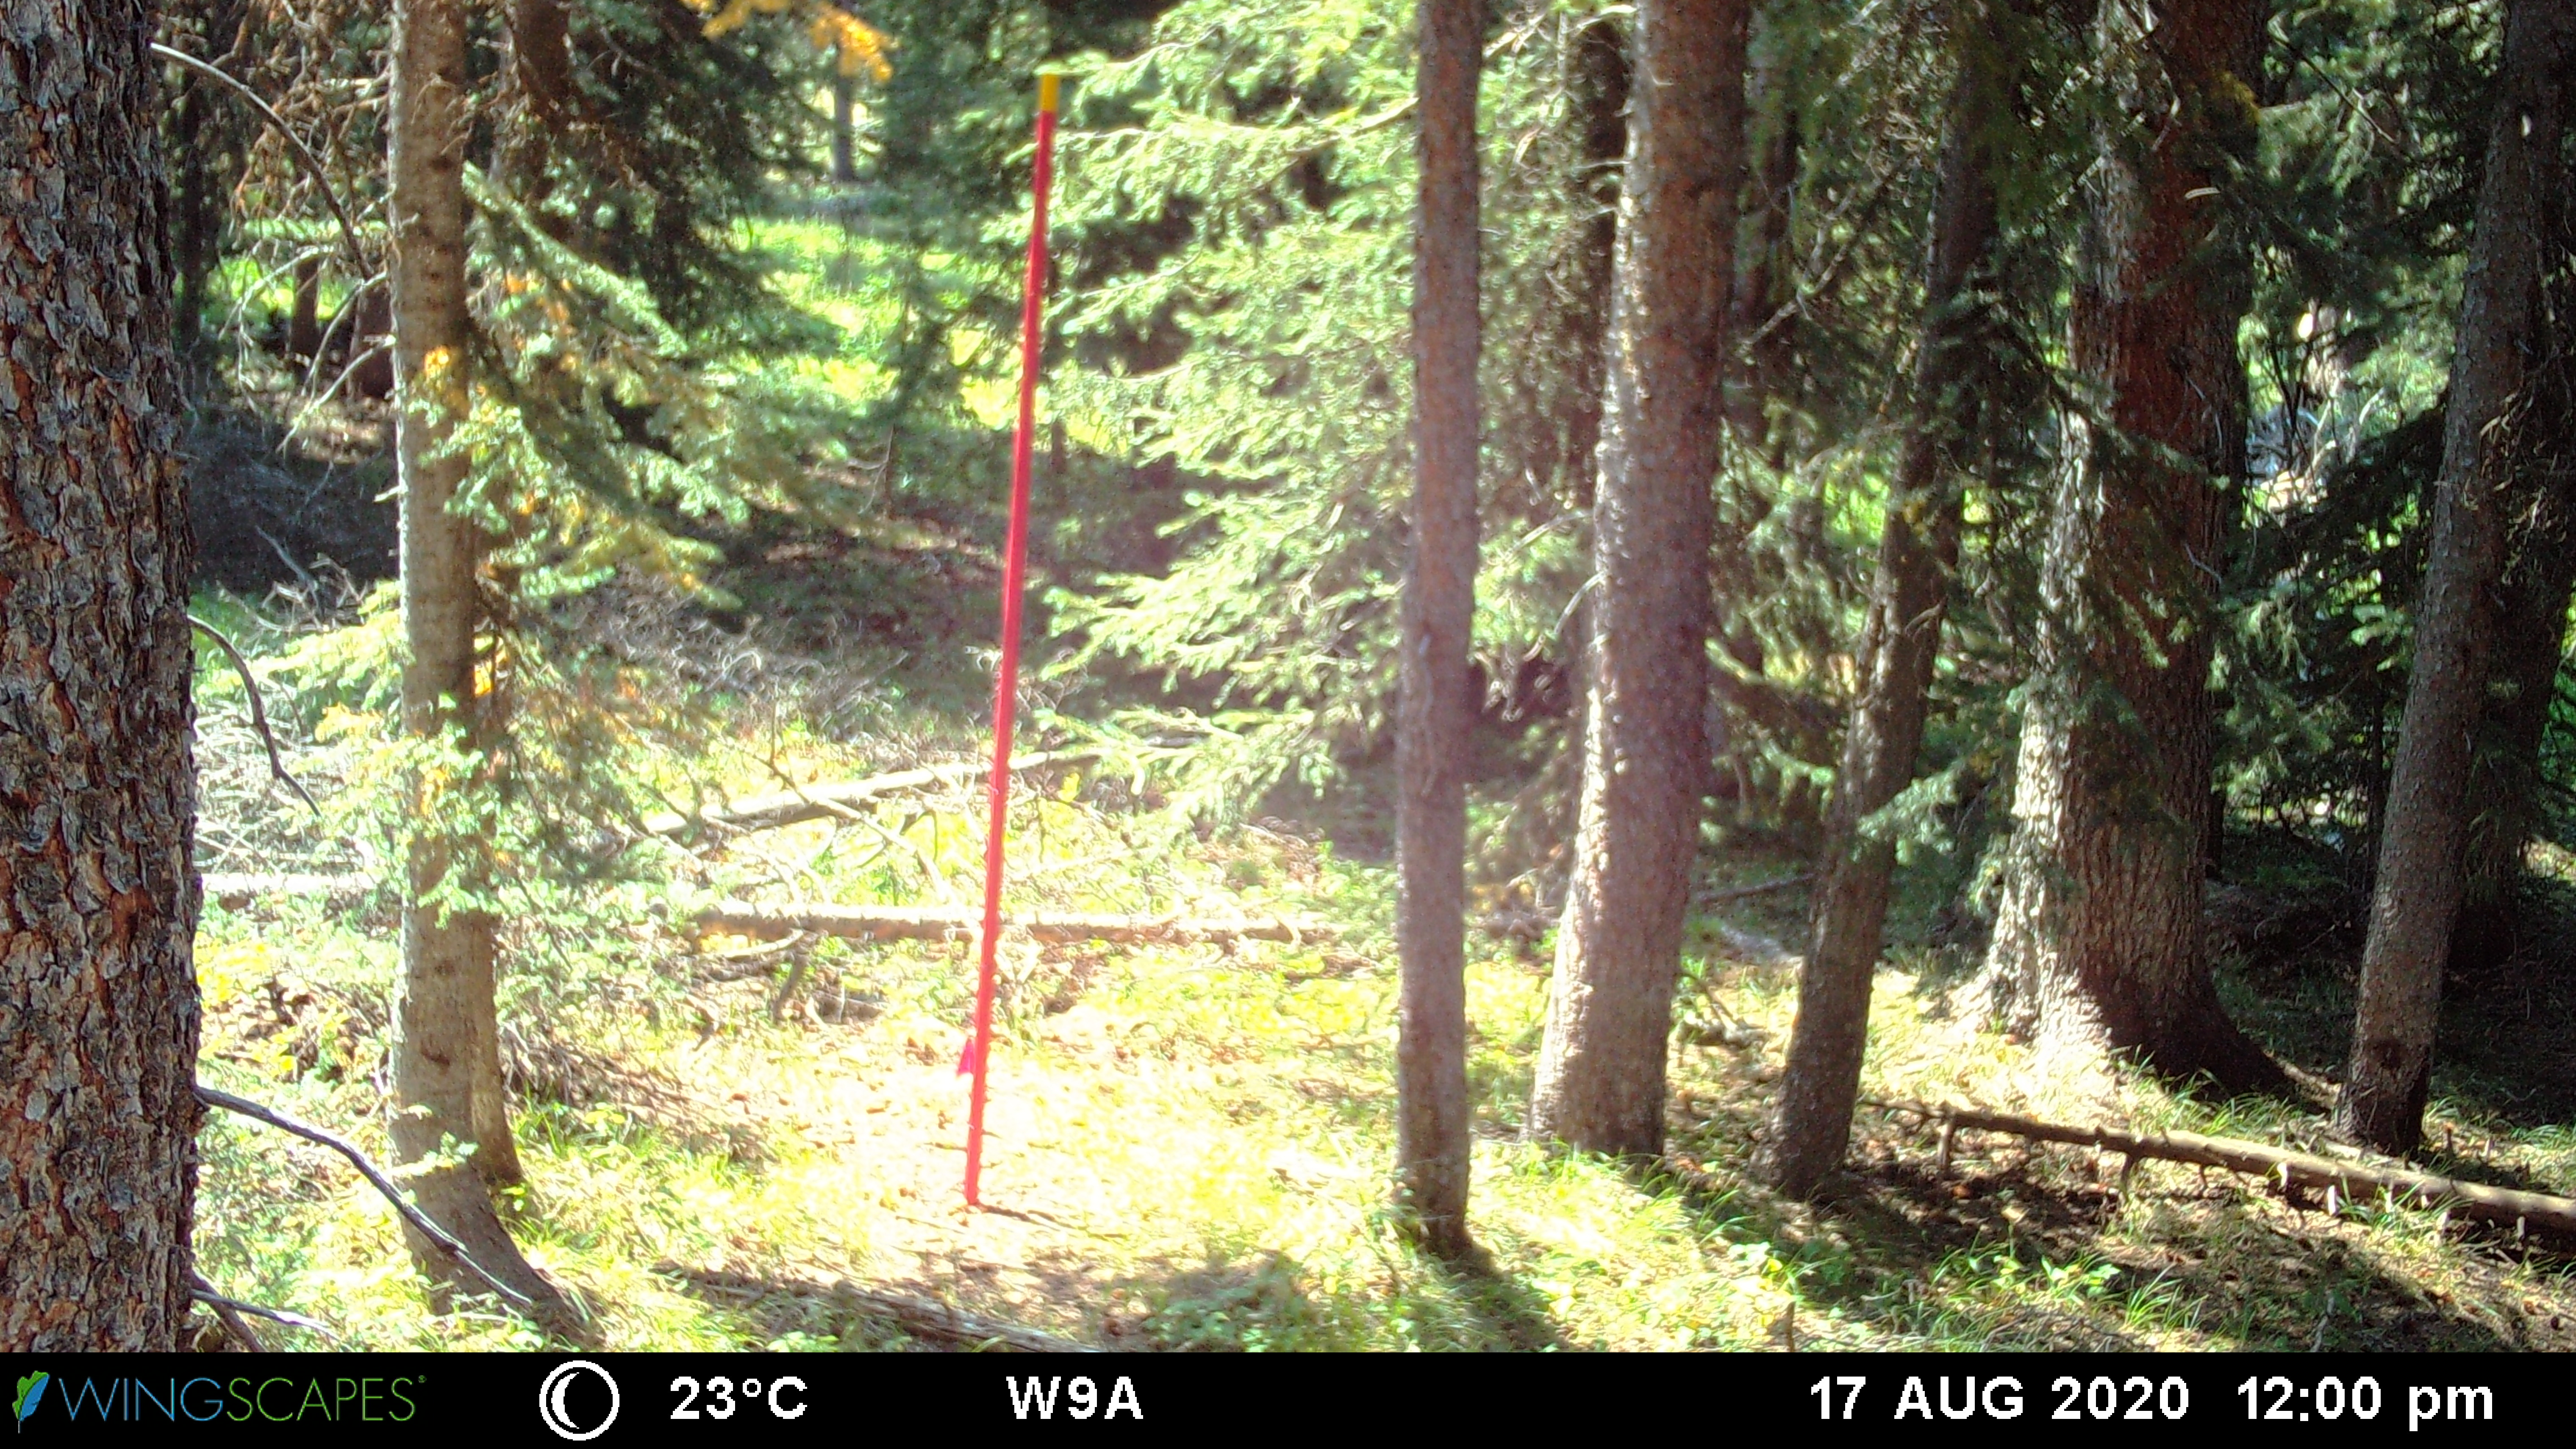

In [86]:
pil_img = Image(filename='/tmp/camera-trap/W9A/'+str(files[-1]),width = 600, height = 300)
display(pil_img)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
!pip install cv2
import numpy as np
import pandas as pd
import cv2
import os

ERROR: Could not find a version that satisfies the requirement cv2
ERROR: No matching distribution found for cv2


In [10]:
#loading image for age detection
pathtxt = ['/tmp/camera-trap/W9A/' + str(f) for f in files[0:489]]
depths = df_open['value']


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPool2D,Dense,Dropout,BatchNormalization,Flatten,Input
from sklearn.model_selection import train_test_split
from PIL import Image
path = "/tmp/camera-trap/W9A/"
pixels = []
age = []
i=0
for img in os.listdir(path)[0:500]:
    ages = depths[i]
    i+=1
    # img = cv2.imread(str(path)+"/"+str(img))
    # src = Image.open(str(path)+"/"+str(img))
    src = cv2.imread(str(path)+"/"+str(img), cv2.IMREAD_UNCHANGED)
    #percent by which the image is resized
    scale_percent = 20
    #calculate the 50 percent of original dimensions
    width =200 # int(src.shape[1] * scale_percent / 100)
    height = 200 # int(src.shape[0] * scale_percent / 100)
    # dsize
    dsize = (width, height)
    # resize image
    output = cv2.resize(src, dsize)
    cv2.imwrite('tmp.jpg',output) 
    # img1 = img.save('tmp', format='JPEG',dpi=(50,50))
    img2 = cv2.imread('tmp.jpg')
    img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2RGB)
    pixels.append(np.array(img2))
    age.append(np.array(ages))
age = np.array(age,dtype=np.int64)
pixels = np.array(pixels)


In [50]:
pixels.shape

(10, 200, 200, 3)

In [12]:


x_train,x_test,y_train,y_test = train_test_split(pixels,age,random_state=100)

input = Input(shape=(200,200,3))
conv1 = Conv2D(140,(3,3),activation="relu")(input)
conv2 = Conv2D(130,(3,3),activation="relu")(conv1)
batch1 = BatchNormalization()(conv2)
pool3 = MaxPool2D((2,2))(batch1)
conv3 = Conv2D(120,(3,3),activation="relu")(pool3)
batch2 = BatchNormalization()(conv3)
pool4 = MaxPool2D((2,2))(batch2)
flt = Flatten()(pool4)
#age
age_l = Dense(128,activation="relu")(flt)
age_l = Dense(64,activation="relu")(age_l)
age_l = Dense(32,activation="relu")(age_l)
age_l = Dense(1,activation="relu")(age_l)


model = Model(inputs=input,outputs=[age_l])
model.compile(optimizer="adam",loss=["mse","sparse_categorical_crossentropy"],metrics=['mae','accuracy'])
save = model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=3)
model.save("model.h5")


Epoch 1/3
3/3 [==============================] - 85s 28s/step - loss: 16717.7891 - mae: 92.2507 - accuracy: 0.1200 - val_loss: 1357.4399 - val_mae: 27.3600 - val_accuracy: 0.0400
Epoch 2/3
3/3 [==============================] - 89s 30s/step - loss: 1456.4000 - mae: 27.9467 - accuracy: 0.0667 - val_loss: 1357.4399 - val_mae: 27.3600 - val_accuracy: 0.0400
Epoch 3/3
3/3 [==============================] - 85s 28s/step - loss: 1456.4000 - mae: 27.9467 - accuracy: 0.0667 - val_loss: 1357.4399 - val_mae: 27.3600 - val_accuracy: 0.0400


0     -0.00300
1      3.00740
2      1.20116
3      1.80324
4      4.21156
        ...   
484    4.81364
485    1.80324
486    4.81364
487    3.00740
488    1.20116
Name: value, Length: 489, dtype: float64

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='id', ylabel='value'>

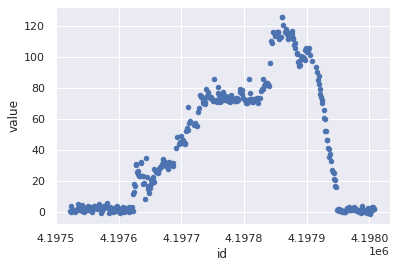

In [109]:
df_copy.plot.scatter(x='id', y='value')


<AxesSubplot:xlabel='id', ylabel='value'>

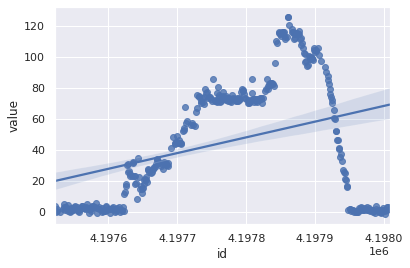

In [111]:
# Regression plot
sns.regplot('id', # Horizontal axis
           'value', # Vertical axis
           data=df_copy)